In [438]:
#importar bibliotecas
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
plt.rcParams['font.family']='Arial'

In [449]:
#importar dataset
df = pd.read_csv('anac.csv', low_memory=False,encoding='cp437')
df.sample(3)

,Ano,ICAO Empresa Aerea,Empresa,Numero Voo,Codigo Autorizacao DI,Codigo Tipo Linha,ICAO Aerodromo Origem,Origem,Pais Origem,ICAO Aerodromo Destino,Destino,Pais Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situacao Voo,Codigo Justificativa
169602,2018,TAM,TAM,3628,0,N,SBNF,NAVEGANTES,BRASIL,SBSP,SAO PAULO,BRASIL,01/07/2018 16:10,01/07/2018 16:00,01/07/2018 17:10,01/07/2018 16:52,REALIZADO,NaN
280789,2021,AAL,AMERICAN AIRLINES INC,930,0,X,SBGR,GUARULHOS,BRASIL,KMIA,MIAMI,ESTADOS UNIDOS DA AMERICA,31/07/2021 23:15,31/07/2021 23:11,01/08/2021 07:50,01/08/2021 07:15,REALIZADO,NaN
99363,2018,TAM,TAM,8070,0,I,SBGR,GUARULHOS,BRASIL,EDDF,FRANKFURT,ALEMANHA,06/07/2018 22:10,06/07/2018 22:19,07/07/2018 10:05,07/07/2018 10:01,REALIZADO,NaN


---
# DATA CLEANING
---







In [440]:
#considerar apenas voos com Tipo Linha Nacional(N) ou Internacional(I) onde país de Origem ou Destino seja o Brasil
#desconsiderar quando ambas Chegada Prevista e Chegada Real em branco
#desconsiderar Destino não informado
df = df[(df['Codigo Tipo Linha'] == 'N') | ((df['Codigo Tipo Linha'] == 'I' ) & 
         ((df['Pais Origem'] == 'BRASIL') | (df['Pais Destino'] == 'BRASIL')))]
df = df[(~(df['Chegada Prevista'].isnull() & df['Chegada Real'].isnull()))]
df = df[(~df['Destino'].isnull())]

#remover colunas incompletas e que não serão analisadas
df.drop('Numero Voo',axis=1, inplace=True)
df.drop('Codigo Autorizacao DI',axis=1, inplace=True)
df.drop('ICAO Aerodromo Origem',axis=1, inplace=True)
df.drop('ICAO Aerodromo Destino',axis=1, inplace=True)
df.drop('Partida Prevista',axis=1, inplace=True)
df.drop('Partida Real',axis=1, inplace=True)
df.drop('Codigo Justificativa',axis=1, inplace=True)


---
#DATA WRANGLING
---

In [441]:
#alterar informaçao de campos:
#-Alterar Situaçao voo para verdadeiro ou falso e considerar sigla para os EUA
#-Criar coluna Restriçoes Turisticas (0-Baixa,1-Média,2-Alta)
df.loc[(df['Situacao Voo'] == 'CANCELADO','Situacao Voo')] = 0
df.loc[(df['Situacao Voo'] == 'REALIZADO','Situacao Voo')] = 1
df['Situacao Voo'] = pd.to_numeric(df['Situacao Voo'])
df.loc[(df['Pais Destino'] == 'ESTADOS UNIDOS DA AMERICA','Pais Destino')] = 'EUA'
df.loc[(df['Ano'] == 2020,'Restricoes Turisticas')] = 2
df.loc[(df['Ano'] == 2021,'Restricoes Turisticas')] = 1
df.update(df['Restricoes Turisticas'].fillna(0))

#-Renomear colunas
df = df.rename(columns={'Situacao Voo':'Realizado'})
df = df.rename(columns={'Codigo Tipo Linha':'Tipo'})

#preencher campos faltantes:
#-Empresa em branco recebe ICAO da empresa
#-Chegada prevista em branco recebe Chegada real
#-Chegada real em branco recebe Chegada prevista desde voo tenha sido realizado
df.update(df['Empresa'].fillna(df['ICAO Empresa Aerea']))
df.drop('ICAO Empresa Aerea',axis=1, inplace=True)
df.update(df['Chegada Prevista'].fillna(df['Chegada Real']))
df.loc[((df['Chegada Real'].isna()) & (df['Realizado'] == 1),'Chegada Real')] = df['Chegada Prevista']

#-Ajustar formato de datas e criar coluna Adiantado e Atrasado em minutos
df['Chegada Real'] = pd.to_datetime(df['Chegada Real'])
df['Chegada Prevista'] = pd.to_datetime(df['Chegada Prevista']) 
df.loc[(df['Chegada Real'] > df['Chegada Prevista'],'Atrasado')] = (df['Chegada Real'] - df['Chegada Prevista'])/ pd.Timedelta(minutes =1)
df.loc[(df['Chegada Real'] <= df['Chegada Prevista']),'Atrasado'] = 0
df.loc[(df['Chegada Real'].isna()),'Atrasado'] = 0

#df.isna().sum()
#df.isnull().sum()

#separar dataframes com voos realizados e cancelados
df_realizado   = df[df['Realizado'] == 1] 
df_cancelado   = df[df['Realizado'] == 0] 
df_queda       = df[(df['Ano'].between(2019,2021)) ]
df_atrasado_30 = df[(df['Atrasado'] >= 30) & (df['Atrasado'] <= 59)] 
df_atrasado_60 = df[df['Atrasado'] >= 60] 

---
# DATA EXPLORING
---




In [442]:
v2019=df_queda[(df_queda['Ano'] == 2019)].groupby(['Ano']).size()
v2020=df_queda[(df_queda['Ano'] == 2020)].groupby(['Ano']).size()
vdif=int(((v2019.values - v2020.values)/df3.values) *100)
vqueda='Queda de ' + str(vdif) + '%'

fig = go.Figure() 
fig.add_trace(go.Scatter(x = df.Ano.value_counts(sort=False).index,
                         y = df.Ano.value_counts(sort=False).values, 
                         mode='lines+markers',
                         line_color='black'))
fig.update_layout(title='Voos programados no mês de Julho',
                  title_font_size=20,
                  width=700,
                  height=500,
                  title_x=0.5,
                  xaxis_title='Ano',
                  yaxis_title='Quantidade',
                  template='plotly_white',
                  font={'size': 10,'color': 'black'},
                  autosize=False)
fig.add_annotation(x=2020, y=5054,
            text=vqueda,
            showarrow=True,
            arrowhead=2,arrowcolor='red', align='left',ax=85,ay=-20,arrowwidth=2,borderwidth=2,borderpad=3,bordercolor='red')

fig.update_xaxes(showgrid=False,showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showgrid=False,showline=True, linewidth=1, linecolor='black',range=[0,100000])

fig.show()

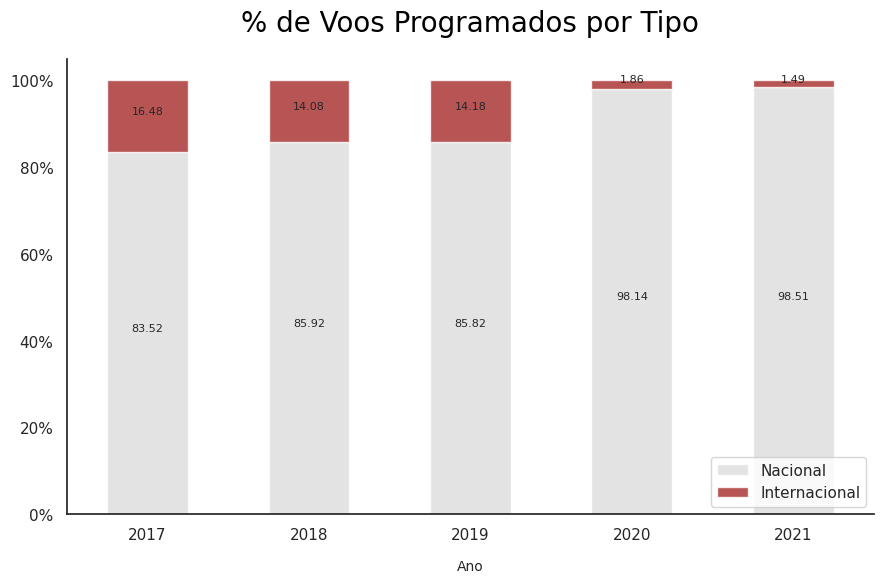

In [443]:
fig,(ax)= plt.subplots(ncols=1)

df.groupby(['Ano','Tipo']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().sort_index(axis=1,ascending=False).plot.bar(stacked=True,color=('Gainsboro','brown'),figsize=(9,6),alpha=0.8,rot=0,ax=ax)
plt.title('% de Voos Programados por Tipo',fontsize= 20,color='black',pad=20)
plt.legend(['Nacional','Internacional'],loc='lower right')
plt.xlabel('Ano', fontsize=10,labelpad=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

for i in ax.patches:
    height = i.get_height()
    width = i.get_width()
    x = i.get_x()
    y = i.get_y()
    label_text = f'{height:.2f}'  
    label_x = x + width / 2
    label_y = y + height / 2

    ax.text(label_x, label_y, label_text, ha='center', va='bottom', fontsize=8)
  
plt.tight_layout()
sns.despine()
plt.show()

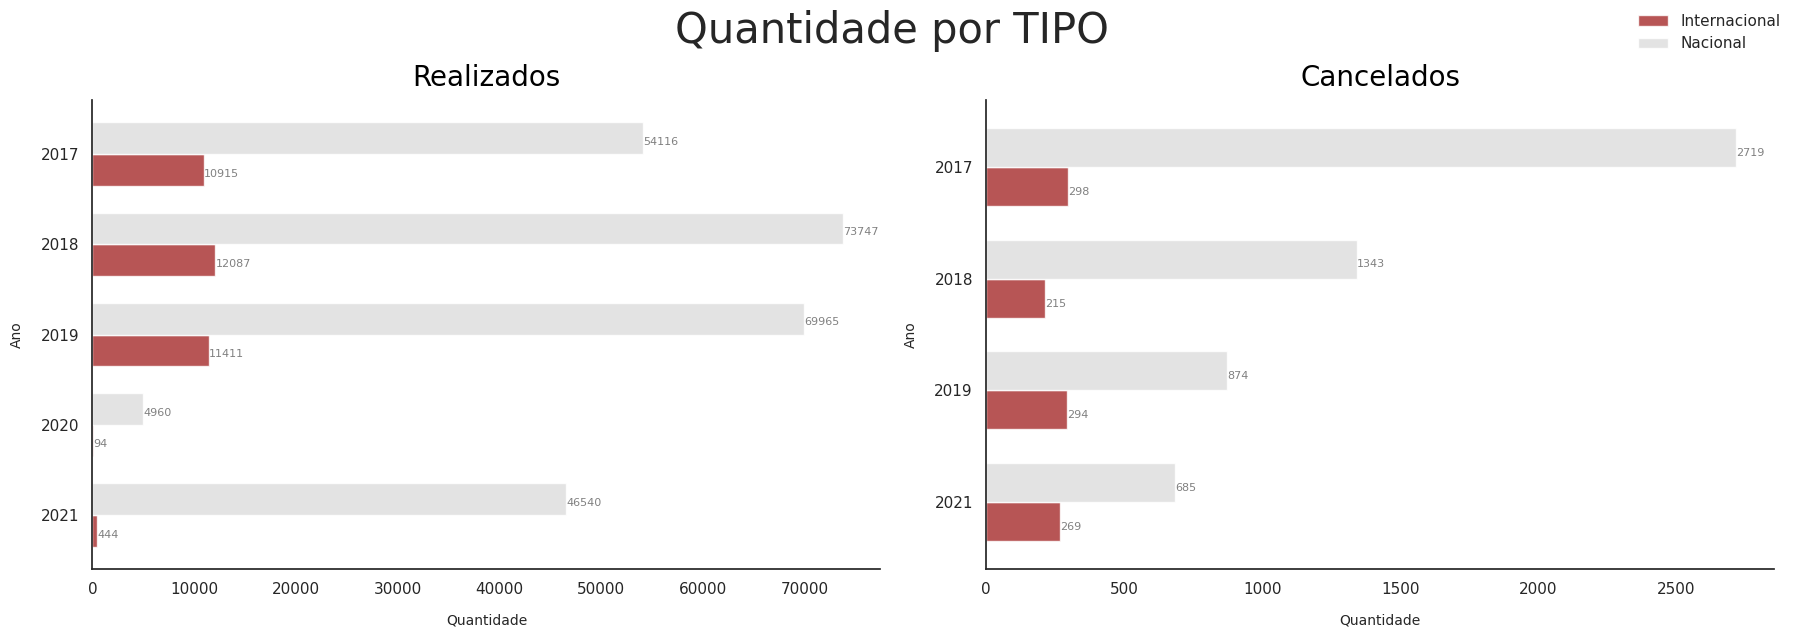

In [444]:
df_rea_tp  = pd.crosstab(df_realizado['Ano'],df_realizado['Tipo']).sort_index(axis=0,ascending=False)
df_canc_tp = pd.crosstab(df_cancelado['Ano'],df_cancelado['Tipo']).sort_index(axis=0,ascending=False)

fig,(ax,ax2)= plt.subplots(ncols=2)
fig.suptitle('Quantidade por TIPO',y=1.06,fontsize=30)

df_rea_tp.plot.barh(color=('brown','Gainsboro'),figsize=(18,6),stacked=False,alpha=0.8,ax=ax,legend=False,width=.7)
ax.set_title('Realizados',fontsize= 20,color='black',pad=10)
ax.set_xlabel('Quantidade', fontsize=10,labelpad=12)
ax.set_ylabel('Ano', fontsize=10,labelpad=12)

df_canc_tp.plot.barh(color=('brown','Gainsboro'),stacked=False,alpha=0.8,ax=ax2,legend=False,width=.7)
ax2.set_title('Cancelados',fontsize= 20,color='black',pad=10)
ax2.set_xlabel('Quantidade', fontsize=10,labelpad=12)
ax2.set_ylabel('Ano', fontsize=10,labelpad=12)

fig.legend(['Internacional','Nacional'],loc='upper right',ncol=1,frameon=False)

for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.10, \
            str(round((i.get_width()), 1)), fontsize=8, color='grey')

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.10, \
            str(round((i.get_width()), 1)), fontsize=8, color='grey')
    
fig.tight_layout()
sns.despine()
fig.show()

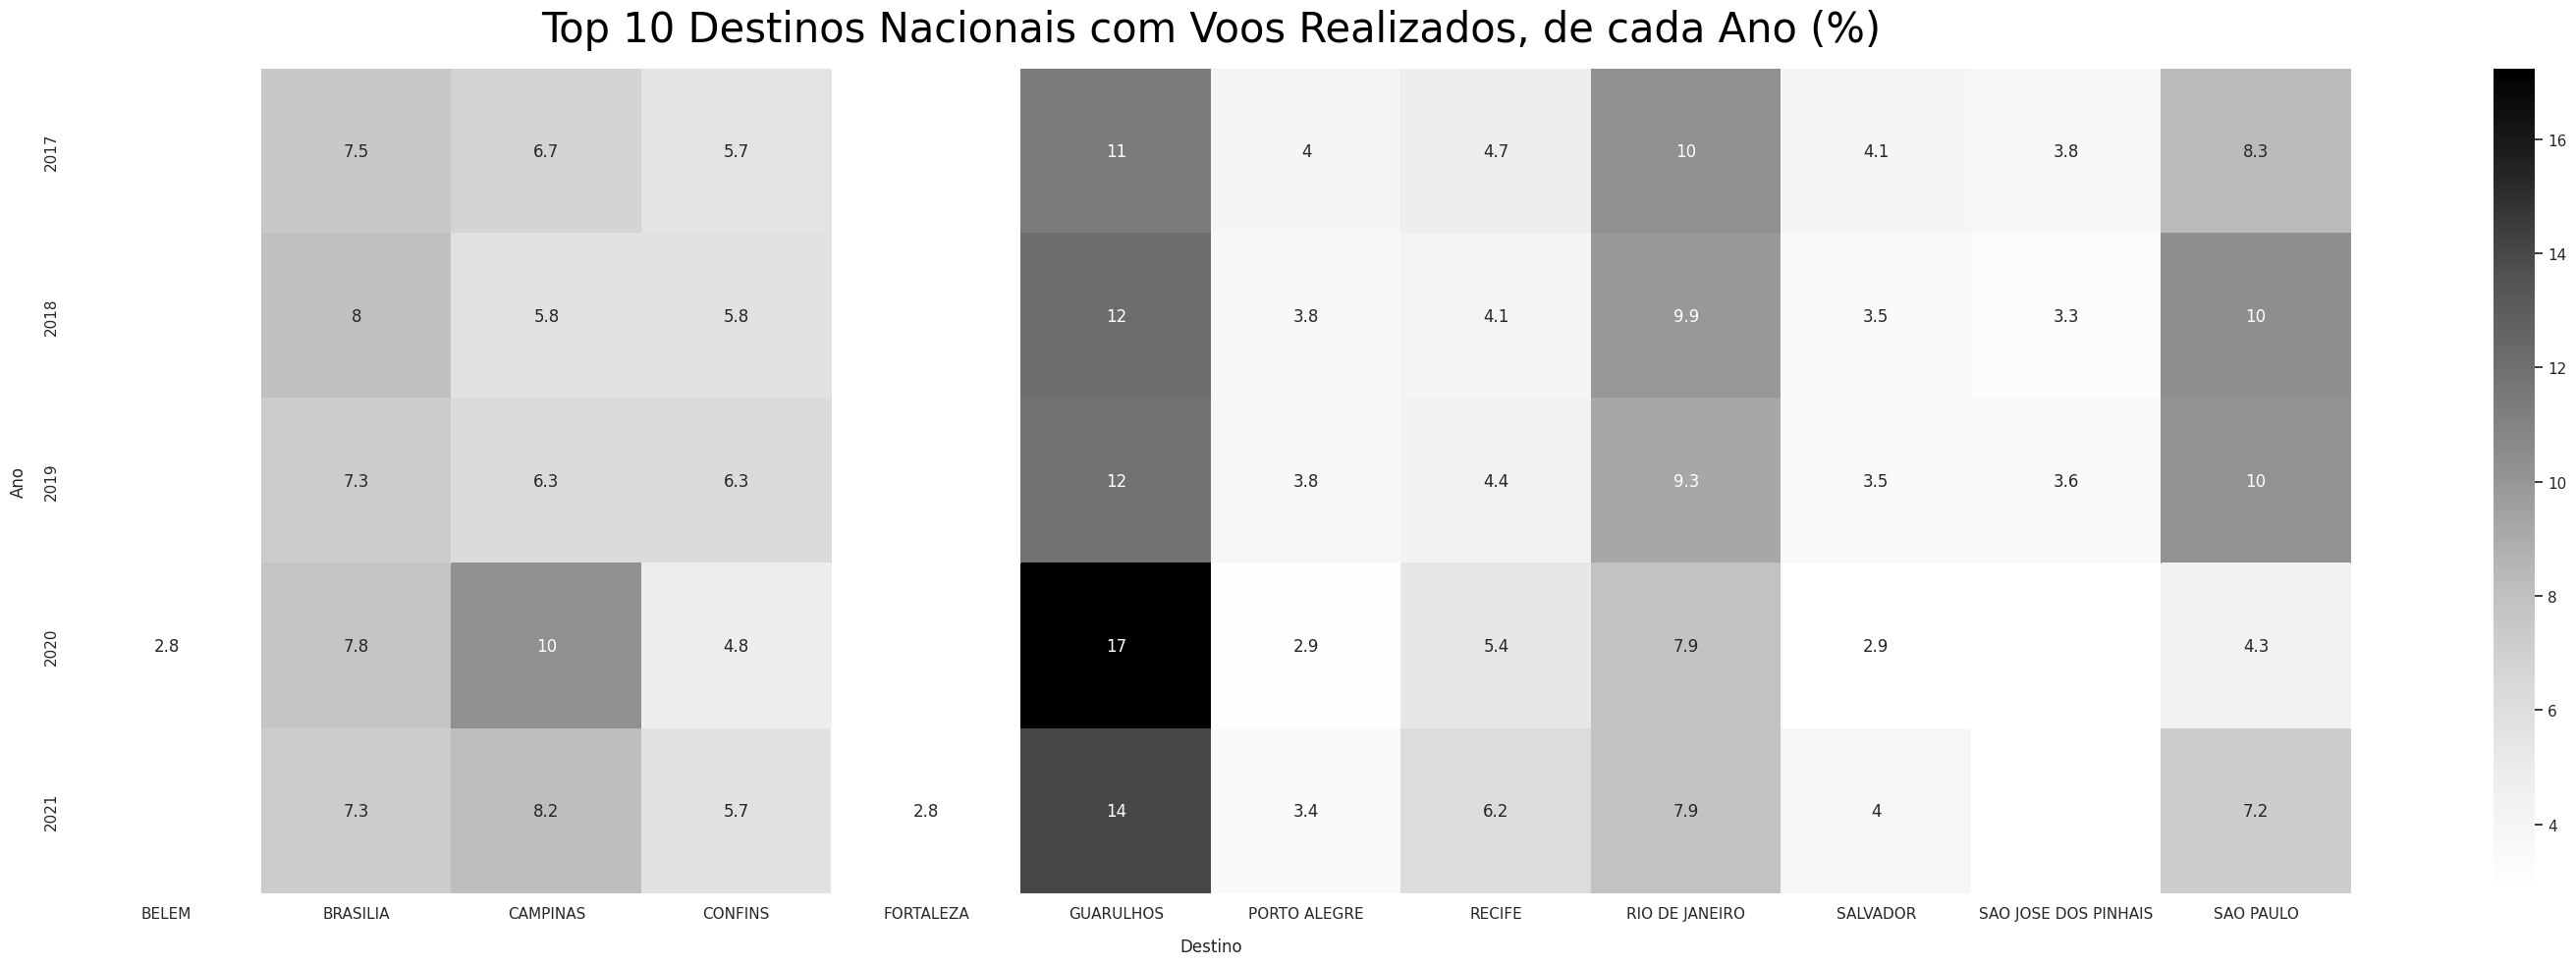

In [445]:
df_top10_cid=df_realizado[df_realizado['Tipo'] == 'N'].groupby(['Ano','Destino']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).groupby('Ano',group_keys=False).nlargest(10).unstack(level=1)
sns.set(rc = {'figure.figsize':(30,10)},style='white')
sns.heatmap(df_top10_cid, annot=True,cmap='Greys')
plt.xlabel('Destino',labelpad=12)
plt.ylabel('Ano',labelpad=12)
plt.title('Top 10 Destinos Nacionais com Voos Realizados, de cada Ano (%)',fontsize= 30,color='black',pad=20)
plt.tight_layout()
plt.show()

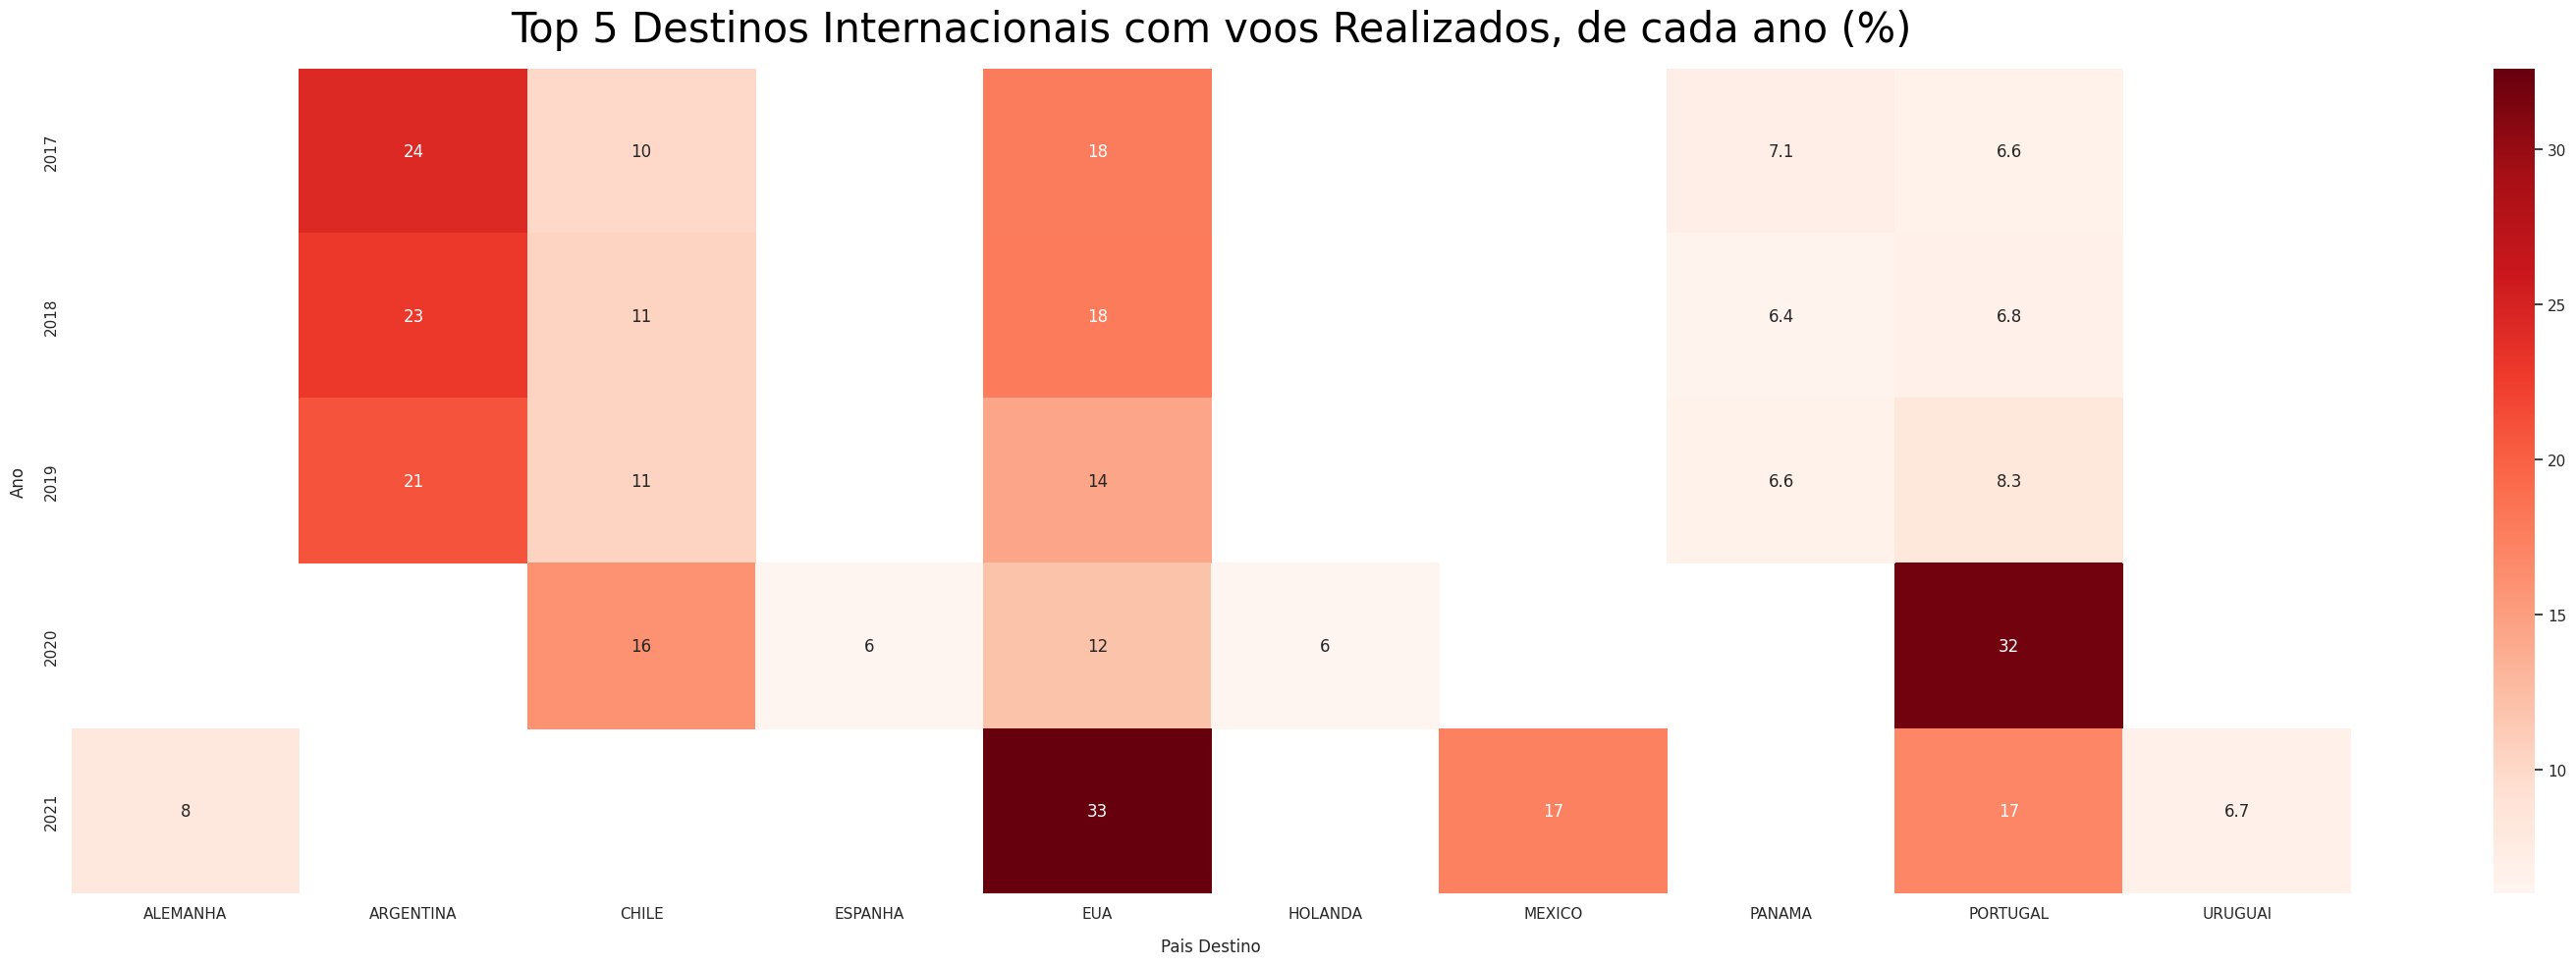

In [446]:
df_top5_pais=df_realizado[(df_realizado['Tipo'] == 'I') & (df_realizado['Pais Destino'] !='BRASIL')].groupby(['Ano','Pais Destino']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).groupby('Ano',group_keys=False).nlargest(5).unstack(level=1)
sns.set(rc = {'figure.figsize':(30,10)},style='white')
sns.heatmap(df_top5_pais, annot=True,cmap='Reds')
plt.xlabel('Pais Destino',labelpad=12)
plt.ylabel('Ano',labelpad=12)
plt.title('Top 5 Destinos Internacionais com voos Realizados, de cada ano (%)',fontsize= 30,color='black',pad=20)
plt.tight_layout()
plt.show()

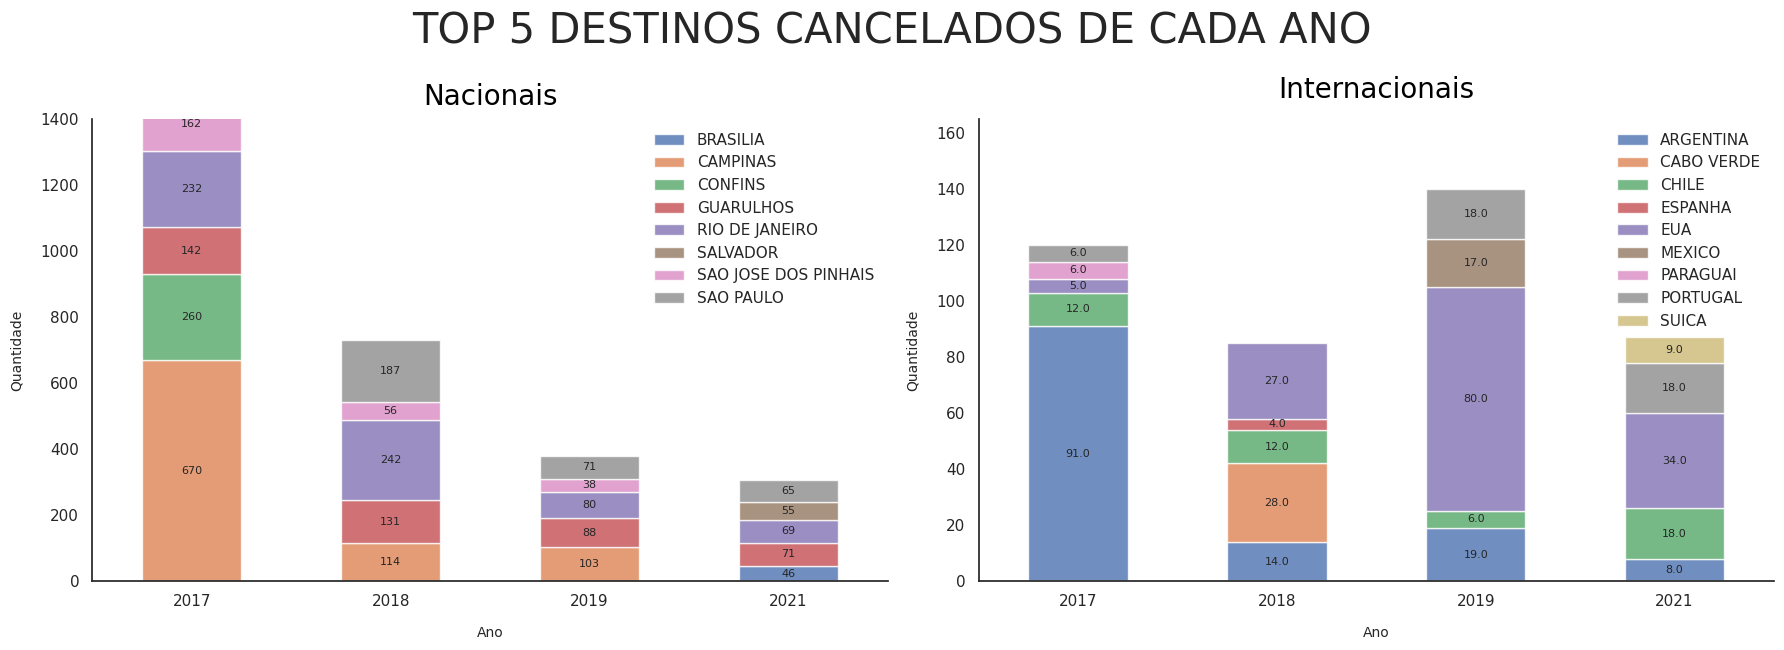

In [447]:
fig,(ax,ax2)= plt.subplots(ncols=2)
fig.suptitle('TOP 5 DESTINOS CANCELADOS DE CADA ANO',y=1.08,fontsize=30)

df_cancelado[df_cancelado['Tipo'] == 'N'].groupby(['Ano','Destino']).size().groupby(
    'Ano',group_keys=False).nlargest(5).unstack(level=1).plot.bar(stacked=True,figsize=(18,6),alpha=0.8,rot=0,ax=ax)
ax.set_title('Nacionais',fontsize= 20,color='black',pad=10)
ax.set_xlabel('Ano', fontsize=10,labelpad=12)
ax.set_ylabel('Quantidade', fontsize=10,labelpad=12)
ax.set_ylim(0,1400)
ax.legend(loc='upper right',frameon=False)

for i in ax.patches:
    height = i.get_height()
    width = i.get_width()
    x = i.get_x()
    y = i.get_y()
    label_text = f'{height:.0f}'  
    label_x = x + width / 2
    label_y = y + height / 2
    if height > 0:
      ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)

df_cancelado[(df_cancelado['Tipo'] == 'I') & (df_cancelado['Pais Destino'] !='BRASIL')].groupby(
    ['Ano','Pais Destino']).size().groupby('Ano',group_keys=False).nlargest(5).unstack(level=1).plot.bar(stacked=True,alpha=0.8,rot=0,ax=ax2)
ax2.set_title('Internacionais',fontsize= 20,color='black',pad=15)
ax2.set_xlabel('Ano', fontsize=10,labelpad=12)
ax2.set_ylabel('Quantidade', fontsize=10,labelpad=12)
ax2.set_ylim(0,165)
ax2.legend(loc='upper right',frameon=False)

for i in ax2.patches:
    height = i.get_height()
    width = i.get_width()
    x = i.get_x()
    y = i.get_y()
    label_text = f'{height:}'  
    label_x = x + width / 2
    label_y = y + height / 2
    if height > 0:
      ax2.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)

plt.tight_layout()
sns.despine()
plt.show()

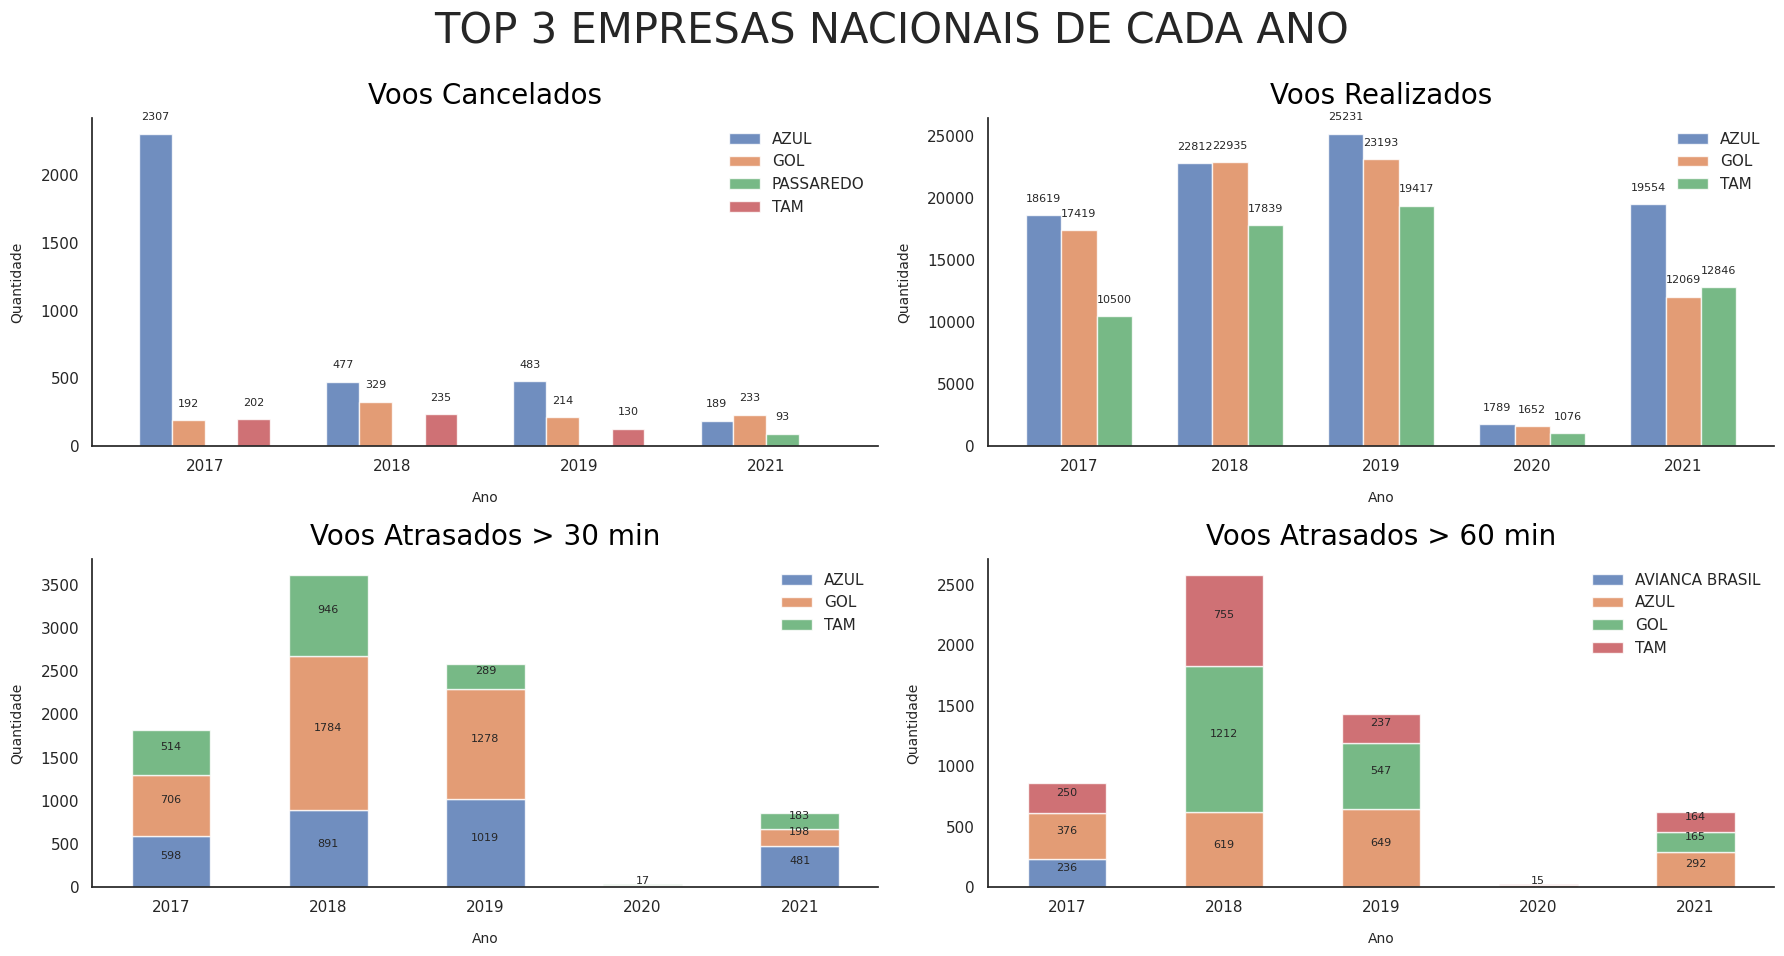

In [448]:
fig,((ax,ax2),(ax3,ax4))= plt.subplots(ncols=2,nrows=2)
fig.suptitle('TOP 3 EMPRESAS NACIONAIS DE CADA ANO',y=1.06,fontsize=30)

df_cancelado[df_cancelado['Tipo'] == 'N'].groupby(['Ano','Empresa']).size().groupby(
    'Ano',group_keys=False).nlargest(3).unstack(level=1).plot.bar(stacked=False,figsize=(18,9),alpha=0.8,rot=0,ax=ax,width=.7)
ax.set_title('Voos Cancelados',fontsize= 20,color='black',pad=10)
ax.set_xlabel('Ano', fontsize=10,labelpad=12)
ax.set_ylabel('Quantidade', fontsize=10,labelpad=12)
ax.legend(loc='upper right',frameon=False)

for i in ax.patches:
  if i.get_height() > 0:
    ax.annotate(format(i.get_height(), '.0f'),
                   (i.get_x() + i.get_width() / 2,
                    i.get_height()), ha='center', va='bottom',
                   size=8, xytext=(0,8),
                   textcoords='offset points') 
       
df_realizado[df_realizado['Tipo'] == 'N'].groupby(['Ano','Empresa']).size().groupby(
    'Ano',group_keys=False).nlargest(3).unstack(level=1).plot.bar(stacked=False,alpha=0.8,rot=0,ax=ax2,width=.7)
ax2.set_title('Voos Realizados',fontsize= 20,color='black',pad=10)
ax2.set_xlabel('Ano', fontsize=10,labelpad=12)
ax2.set_ylabel('Quantidade', fontsize=10,labelpad=12)
ax2.legend(loc='upper right',frameon=False)

for i in ax2.patches:
  if i.get_height() > 0:
    ax2.annotate(format(i.get_height(), '.0f'),
                   (i.get_x() + i.get_width() / 2,
                    i.get_height()), ha='center', va='bottom',
                   size=8, xytext=(0,8),
                   textcoords='offset points') 

df_atrasado_30[df_atrasado_30['Tipo'] == 'N'].groupby(['Ano','Empresa']).size().groupby(
    'Ano',group_keys=False).nlargest(3).unstack(level=1).plot.bar(stacked=True,alpha=0.8,rot=0,ax=ax3)
ax3.set_title('Voos Atrasados > 30 min',fontsize= 20,color='black',pad=10)
ax3.set_xlabel('Ano', fontsize=10,labelpad=12)
ax3.set_ylabel('Quantidade', fontsize=10,labelpad=12)
ax3.legend(loc='upper right',frameon=False)

for i in ax3.patches:
    height = i.get_height()
    width = i.get_width()
    x = i.get_x()
    y = i.get_y()
    label_text = f'{height:.0f}'  
    label_x = x + width / 2
    label_y = y + height / 2
    if height >= 15:
      ax3.text(label_x, label_y, label_text, ha='center', va='bottom', fontsize=8)

df_atrasado_60[df_atrasado_60['Tipo'] == 'N'].groupby(['Ano','Empresa']).size().groupby(
    'Ano',group_keys=False).nlargest(3).unstack(level=1).plot.bar(stacked=True,alpha=0.8,rot=0,ax=ax4)
ax4.set_title('Voos Atrasados > 60 min',fontsize= 20,color='black',pad=10)
ax4.set_xlabel('Ano', fontsize=10,labelpad=12)
ax4.set_ylabel('Quantidade', fontsize=10,labelpad=12)
ax4.legend(loc='upper right',frameon=False)

for i in ax4.patches:
    height = i.get_height()
    width = i.get_width()
    x = i.get_x()
    y = i.get_y()
    label_text = f'{height:.0f}'  
    label_x = x + width / 2
    label_y = y + height / 2
    if height >= 15:
      ax4.text(label_x, label_y, label_text, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
sns.despine()
plt.show()

---
# INSIGHTS
---